In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sever.data_loader import make_mask

In [2]:
img_size = 256 * 1600
img_size

409600

In [3]:
train_csv = '../data/raw/severstal-steel-defect-detection/train.csv'
df = pd.read_csv(train_csv)
df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
N_CLASSES = 4
rle_cols = [f'rle{i}' for i in range(N_CLASSES)]

In [5]:
df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
df.columns = rle_cols
df['defects'] = df.count(axis=1)
df = df.loc[df.defects > 0, :]
df.head()

,rle0,rle1,rle2,rle3,defects
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1


In [6]:
filenames = df.index.values
filenames[:3]

array(['0002cc93b.jpg', '0007a71bf.jpg', '000a4bcdd.jpg'], dtype=object)

In [7]:
np.random.shuffle(filenames)
filenames[:3]

array(['374493292.jpg', '8fe172794.jpg', '24c9c291d.jpg'], dtype=object)

In [8]:
df2 = df.copy()
df2.index = filenames
df2.sort_index(inplace=True)
df2.head()

,rle0,rle1,rle2,rle3,defects
0002cc93b.jpg,NaN,NaN,373611 89 373826 185 374041 226 374276 247 374...,NaN,1
0007a71bf.jpg,NaN,NaN,84 28 318 56 553 83 787 111 1032 125 1288 125 ...,NaN,1
000a4bcdd.jpg,NaN,NaN,52349 132 52605 132 52861 132 53117 132 53373 ...,NaN,1
000f6bf48.jpg,NaN,NaN,139523 16 139779 48 140035 80 140291 111 14054...,NaN,1
0014fce06.jpg,NaN,NaN,222167 9 222415 19 222670 22 222926 25 223181 ...,NaN,1


In [26]:
class RLE:
    """
    Encapsulates run-length-encoding functionality.
    """
    
    MASK_H = 256
    MASK_W = 1600
    
    @classmethod
    def from_str(cls, s):
        if s != s:
            return cls()
        list_ = [int(n) for n in s.split(' ')]
        return cls.from_list(list_)
    
    @classmethod
    def from_mask(cls, mask):
        pixels = mask.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return cls.from_list(runs)
    
    @classmethod
    def from_list(cls, list_):
        n_items = len(list_) // 2
        items = np.zeros((n_items, 2), dtype=np.uint64)
        for i in range(n_items):
            items[i, 0] = list_[i * 2]
            items[i, 1] = list_[i * 2 + 1]
        return cls(items)
    
    def __init__(self, items=np.zeros((0, 0))):
        self._items = items
        
    @property
    def items(self):
        return self._items
    
    def __iter__(self):
        for idx, item in enumerate(self.items):
            yield (item[0], item[1])  # run, length
    
    def __len__(self):
        return self.items.shape[0]
    
    def to_mask(self):
        mask = np.zeros(self.MASK_H * self.MASK_W, dtype=np.uint8)
        for run, length in self:
            mask[run:run + length] = 1
        return mask.reshape(self.MASK_H, self.MASK_W, order='F')
    
    def to_str_list(self):
        list_ = []
        for run, length in self:
            list_.append(str(run))
            list_.append(str(length))
        return list_
    
    def __str__(self):
        if len(self) == 0:
            return ''
        return ' '.join(self.to_str_list())
    
    def __repr__(self):
        return self.__str__()

In [13]:
r1 = df.loc['0007a71bf.jpg'][rle_cols]
r1

rle0                                                  NaN
rle1                                                  NaN
rle2    84 28 318 56 553 83 787 111 1032 125 1288 125 ...
rle3                                                  NaN
Name: 0007a71bf.jpg, dtype: object

In [14]:
r2 = df2.loc['0007a71bf.jpg'][rle_cols]
r2

rle0                                                  NaN
rle1                                                  NaN
rle2    84 28 318 56 553 83 787 111 1032 125 1288 125 ...
rle3                                                  NaN
Name: 0007a71bf.jpg, dtype: object

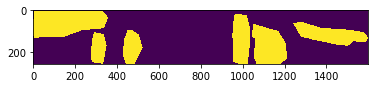

In [24]:
m1 = make_mask(r1)[:, :, 2]
plt.imshow(m1)

In [25]:
RLE.from_mask(m1)

array([   987,     31,   1070, ...,     43, 409069,    113])

In [16]:
def make_mask(labels):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    masks = np.zeros((256, 1600, 4), dtype=np.float32)  # float32 is V.Imp

    for idx, label in enumerate(labels.values):
        if label == label:  # NaN check
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return masks

In [17]:
%%timeit
make_mask(r1)

2.74 ms ± 657 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
rles = [RLE.from_str(r) for r in r1]

In [20]:
%%timeit
[rle.to_mask() for rle in rles]

1.84 ms ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [63]:
rles[0].items

array([], shape=(0, 0), dtype=float64)

In [ ]:
df_empty.empty

In [ ]:
df_nodef = df.loc[df.defects > 0, :]
df_nodef.shape